# Exercise 2: Train a VAE to produce the samples similar to the dataset.




1.   Write DataLoaders
2.   Train a VAE
3.   Show a few samples and the correspoding decoded images
4.   Show a few of the generated samples



Note: The train and test images are in the csv files, **ALL data should be used to train the VAE**

Take special care of reading images and make sure the images are indeed correct. You will have to plot the image to see it.

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torchvision import models,transforms
from torchvision.utils import make_grid
from torchvision.datasets import MNIST
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.tensorboard import SummaryWriter
from torchsummary import summary
from torch.utils.data import Dataset, DataLoader
import imageio as imo
import os
import pandas as pd

In [1]:
!wget -O data.zip https://www.dropbox.com/s/tzs174hrjs1rbzs/FashionMNIST.zip?dl=0
!unzip data.zip

--2023-05-28 19:44:01--  https://www.dropbox.com/s/tzs174hrjs1rbzs/FashionMNIST.zip?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.3.18, 2620:100:6018:18::a27d:312
Connecting to www.dropbox.com (www.dropbox.com)|162.125.3.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/tzs174hrjs1rbzs/FashionMNIST.zip [following]
--2023-05-28 19:44:02--  https://www.dropbox.com/s/raw/tzs174hrjs1rbzs/FashionMNIST.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucbb44f062dd57af043511e5ee8f.dl-eu.dropboxusercontent.com/cd/0/inline/B84e3Lbx2Kiz152LgJWBpRaLvjUcN0ErJu1_eaPtWWaH4yar9kEqhbnk9Tiwft3Q-kASVv103SgyVMd42IDQAaNAAhVu5o_ZvAFVvNWhfcCAeE57TZ8dTy0Dc1tr4-HPLDYzhhuahUUtmAYCIUuONyWYBfym-6qR1XZbUhw05r0UTQ/file# [following]
--2023-05-28 19:44:02--  https://ucbb44f062dd57af043511e5ee8f.dl-eu.dropboxusercontent.com/cd/0/inline/B84e3Lbx2Kiz152LgJWBpRaLvjUcN0ErJu1_eaPtWWaH4yar9kEqhbnk9

In [34]:
tans = transforms.ToTensor()
class myDataset(Dataset):
  def __init__(self,concatenated_df):
    super().__init__()
    df = concatenated_df
    data = df.to_numpy()
    self.labels = data[:,0]
    self.images = data[:,1:]


  def __len__(self):
    return  self.images.shape[0]

  def __getitem__(self,idx):
    im = self.images[idx,:].reshape(28,28)
    im = tans(im)
    label = self.labels[idx]
    
    return (im,label)

In [32]:
df = pd.read_csv("/content/fashion-mnist_train.csv")
df2 = pd.read_csv("/content/fashion-mnist_test.csv")

In [33]:
concatenated_df = pd.concat([df, df2])

In [35]:
dataset = myDataset(concatenated_df)
train_loader = DataLoader(dataset,batch_size = 64, shuffle=False  )
batch = next(iter(train_loader))
batch[0].shape
batch[1].shape

torch.Size([64])

In [36]:
batch[0].shape

torch.Size([64, 1, 28, 28])

torch.Size([64, 1, 28, 28])


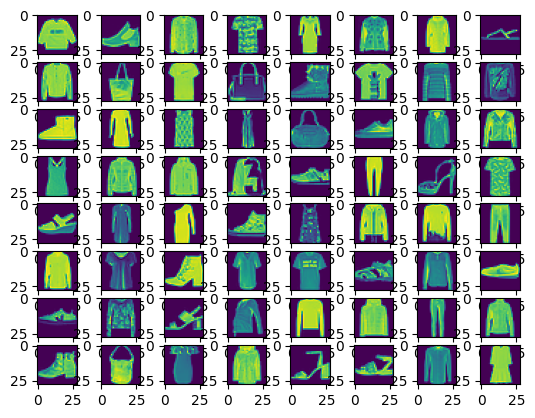

In [41]:
print(batch[0].shape)
for i in range(64):
  plt.subplot(8,8,i+1)
  plt.imshow(batch[0][i][:].permute(1, 2, 0))

In [42]:
class VAE(nn.Module):
  def __init__(self, nz):
    super().__init__()
    self.nz = nz
    self.econv1 = nn.Conv2d(1, 16, 3, 1, 1)
    self.ebn1 = nn.BatchNorm2d(16)
    self.econv2 = nn.Conv2d(16, 32, 3, 2, 1)
    self.ebn2 = nn.BatchNorm2d(32)
    self.econv3 = nn.Conv2d(32, 64, 3, 2, 1)
    self.ebn3 = nn.BatchNorm2d(64)
    self.elinear1 = nn.Linear(64*7*7, 100)
    self.ebn4 = nn.BatchNorm1d(100)
    self.elinear2 = nn.Linear(100, self.nz)
    
    self.dlinear1 = nn.Linear(self.nz, 100)
    self.dbn1 = nn.BatchNorm1d(100)
    self.dlinear2 = nn.Linear(100, 64*7*7)
    self.dbn2 = nn.BatchNorm1d(64*7*7)
    self.dtconv1 = nn.ConvTranspose2d(64, 32, 3, 2, 1, output_padding = 1)
    self.dbn3 = nn.BatchNorm2d(32)
    self.dtconv2 = nn.ConvTranspose2d(32, 16, 3, 2, 1, output_padding = 1)
    self.dbn4 = nn.BatchNorm2d(16)
    self.dtconv3 = nn.ConvTranspose2d(16, 1, 3, 1, 1)


    self.plinear1 = nn.Linear(self.nz, self.nz)
    self.plinear2 = nn.Linear(self.nz, self.nz)


  def encoder_head(self, x):
    x = torch.relu(self.econv1(x))
    x = self.ebn1(x)

    x = torch.relu(self.econv2(x))
    x = self.ebn2(x)

    x = torch.relu(self.econv3(x))
    x = self.ebn3(x)

    x = x.view(-1,64*7*7)

    x = torch.relu(self.elinear1(x))
    x = self.ebn4(x)

    x = torch.sigmoid(self.elinear2(x))
    return x


  def get_params(self, x):
    mu = self.plinear1(x)
    logvar = self.plinear2(x)
    return mu, logvar

  def encoder(self, x):
    x = self.encoder_head(x)
    mu, logvar = self.get_params(x)
    z = torch.exp(0.5*logvar) * torch.randn_like(logvar) + mu ##
    return z, mu, logvar

  def decoder(self, x):
    x = torch.relu(self.dlinear1(x))
    x = self.dbn1(x)

    x = torch.relu(self.dlinear2(x))
    x = self.dbn2(x)

    x = x.view(-1, 64,7,7)

    x = torch.relu(self.dtconv1(x))
    x = self.dbn3(x)

    x = torch.relu(self.dtconv2(x))
    x = self.dbn4(x)

    x = torch.sigmoid(self.dtconv3(x))

    return x


  def forward(self, x):
    z, mu, logvar = self.encoder(x)
    x = self.decoder(z)
    return z, x, mu, logvar
    
  

In [43]:
def get_loss(x, xhat, mu, logvar):
  m = 1e-4
  recon_loss = F.mse_loss(x,xhat)
  kld_loss = torch.mean(torch.sum(-0.5*(1+logvar - torch.exp(logvar)- mu**2), dim=1), dim=0)
  loss = m*kld_loss + (1-m)*recon_loss
  return loss


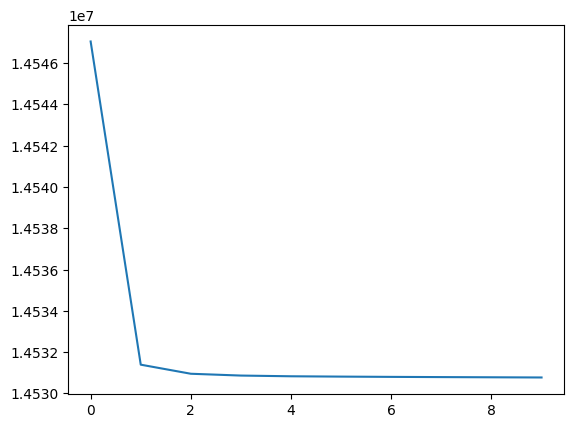

In [46]:
device = torch.device("cuda:0")
net = VAE(10).to(device)
num_epochs = 10
lr = 1e-4
opt = optim.Adam(net.parameters(), lr = lr)
#opt = SophiaG(net.parameters(), lr=2e-4, betas=(0.965, 0.99), rho = 0.01, weight_decay=1e-1)

ls = []
for i in range(num_epochs):
  total_loss = 0
  for batch in train_loader:
    X = batch[0].to(device)
    X = X.float()  # Convert input data to float type
    Z, Xhat, mu, logvar = net(X)
    loss = get_loss(Xhat, X, mu, logvar)
    total_loss+= loss.item()
    opt.zero_grad()
    loss.backward()
    opt.step()
  ls.append(total_loss)
plt.plot(ls)

In [52]:
X = X.detach().cpu()
Xhat = Xhat.detach().cpu()

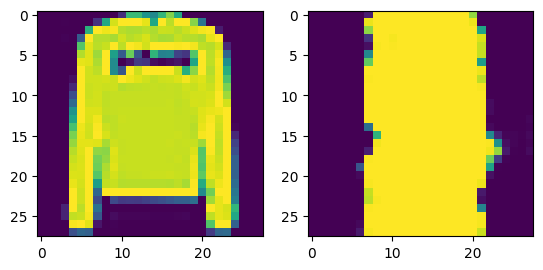

In [53]:
plt.subplot(121)
plt.imshow(X[2,:].reshape(28,28))
plt.subplot(122)
plt.imshow(Xhat[2,:].reshape(28,28))

In [49]:
num_samples = 64
z = torch.randn((num_samples, 10)).to(device)
with torch.no_grad():
  Xhat = net.decoder(z)

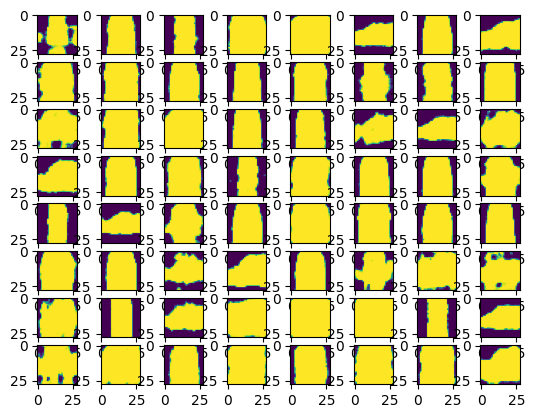

In [50]:
for i in range(64):
  plt.subplot(8,8,i+1)
  plt.imshow(Xhat.cpu()[i,0,:,:])

In [55]:
with torch.no_grad():
  net.eval()
  z = torch.randn(10, 10).to(device)

  Xgen = net.decoder(z)

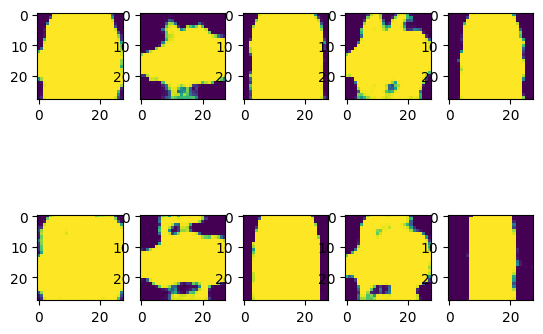

In [56]:
for i in range(10):
  plt.subplot(2,5,i+1)
  plt.imshow(Xgen.cpu().numpy()[i,0,:,:])